In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import PIL
from tqdm import tqdm
import seaborn as sns

In [2]:
PATH_CELL_CSV = '/home/jose/Programas/OCD-Evaluation/data/consolidated_df.csv'
PATH_TEST_IMGS = '/home/jose/Programas/OCD-Evaluation/data/OCD/test/images'
PATH_OUTPUT = '/home/jose/Programas/OCD-Evaluation/detection_outputs'

Get subset of data containing the test set images with detection threshold > 0.5

In [3]:
df = pd.read_csv(PATH_CELL_CSV)   
df = df[df['type'] == 'test']
df = df[df['detection_threshold'] >= 0.5]
df

,file_name,evaluator,cx,cy,width,height,angle,detection_threshold,type
0,exp_M4_Mauricio_mcr5_frame_40,ground-truth,29.50000,247.00000,96.000000,59.000000,1.570796,1.000000,test
1,exp_M4_Mauricio_mcr5_frame_40,ground-truth,104.39654,581.25867,122.377594,83.773506,1.165904,1.000000,test
2,exp_M4_Mauricio_mcr5_frame_40,ground-truth,196.55138,641.21810,88.093500,149.375370,1.098167,1.000000,test
3,exp_M4_Mauricio_mcr5_frame_40,ground-truth,399.00006,710.00006,143.676730,108.300520,0.501013,1.000000,test
4,exp_M4_Mauricio_mcr5_frame_40,ground-truth,233.97860,826.72015,88.457920,144.678960,0.096918,1.000000,test
...,...,...,...,...,...,...,...,...,...
23971,exp_L1.4_Luana_A172_cloneF9(mito)+H2B_TMZ3hora...,rotated-retinanet-rbox-le90_r50_fpn_rr_probiou...,417.11810,394.56900,27.534970,21.130419,-0.618969,0.545403,test
23972,exp_L1.4_Luana_A172_cloneF9(mito)+H2B_TMZ3hora...,rotated-retinanet-rbox-le90_r50_fpn_rr_probiou...,775.51776,595.47485,52.739380,17.823190,-1.074229,0.543860,test
23973,exp_L1.4_Luana_A172_cloneF9(mito)+H2B_TMZ3hora...,rotated-retinanet-rbox-le90_r50_fpn_rr_probiou...,1023.23850,299.19824,54.278316,16.461826,-1.155235,0.520266,test
23974,exp_L1.4_Luana_A172_cloneF9(mito)+H2B_TMZ3hora...,rotated-retinanet-rbox-le90_r50_fpn_rr_probiou...,790.98660,632.25670,50.133990,18.073210,-0.080935,0.517049,test


Merge human annotators as Ground Truth

In [4]:
evals_dict = {
    'angelo': 'ground-truth', 
    'fernanda': 'ground-truth',
    'oriented-rcnn-le90_r50_fpn_rr_1x_ocd-cropped' : 'oriented r-cnn',
    'oriented-reppoints-qbox_r50_fpn_1x_ocd-cropped' : 'oriented reppoints',
    'r3det-oc_r50_fpn_rr_1x_ocd-cropped' : 'r3det',
    'r3det-oc_r50_fpn_rr_kld-stable_1x_ocd-cropped' : 'r3det + kld',
    'r3det-oc_r50_fpn_rr_probiou_1x_ocd-cropped' : 'r3det + probiou',
    'redet-le90_re50_refpn_rr_1x_ocd-cropped' : 'redet',
    'roi-trans-le90_r50_fpn_rr_1x_ocd-cropped' : 'roi transformer',
    'rotated-fcos-hbox-le90_r50_fpn_psc_rr_1x_ocd-cropped' : 'fcos',
    'rotated-fcos-le90_r50_fpn_rr_1x_ocd-cropped' : 'fcos psc',
    'rotated-retinanet-rbox-le90_r50_fpn_rr_1x_ocd-cropped' : 'retinanet',
    'rotated-retinanet-rbox-le90_r50_fpn_rr_gwd_1x_ocd-cropped' : 'retinanet + gwd',
    'rotated-retinanet-rbox-le90_r50_fpn_rr_kld-stable_1x_ocd-cropped' : 'retinanet + kld',
    'rotated-retinanet-rbox-le90_r50_fpn_rr_probiou_1x_ocd-cropped' : 'retinanet + probiou',
    's2anet-le90_r50_fpn_rr_1x_ocd-cropped' : 's2anet',

    }
df.replace({'evaluator': evals_dict}, inplace=True)
df['evaluator'].unique()

array(['ground-truth', 'fcos psc', 'fcos', 'redet', 'retinanet',
       'retinanet + kld', 'r3det + kld', 'oriented reppoints',
       'oriented r-cnn', 'retinanet + gwd', 'r3det', 'roi transformer',
       'r3det + probiou', 's2anet', 'retinanet + probiou'], dtype=object)

Run analysis over image groups 

In [5]:
image_groups = df.groupby('file_name')

dfs_list = []

for image_name, image_group in image_groups:
    image = PIL.Image.open(os.path.join(PATH_TEST_IMGS, image_name) + '.png')
    im_w, im_h = image.size
    im_area = im_h * im_w

    evaluator_groups = image_group.groupby('evaluator')    

    for evaluator, evaluator_group in evaluator_groups:
        cell_wh = evaluator_group[['width', 'height']]

        # Cell count
        cell_count = len(evaluator_group)

        # Confluence
        cell_areas = cell_wh.prod(axis=1)
        sum_cell_areas = cell_areas.sum()
        confluence = sum_cell_areas / im_area
    
        # Polarity
        cell_max_semiaxes = cell_wh.max(axis=1)
        cell_min_semiaxes = cell_wh.min(axis=1)
        polarities = (cell_max_semiaxes / cell_min_semiaxes).to_list()

        group_dict = {'img_name': image_name, 'evaluator': evaluator, 
                      'cell_count': cell_count, 'confluence': confluence, 'polarities': [polarities]}
        group_df = pd.DataFrame(group_dict)

        dfs_list.append(group_df)

df_analysis = pd.concat(dfs_list)

df_analysis.sort_values(by='img_name', ascending=False, inplace=True)

# Replace img_name column with index
name_col = df_analysis['img_name']
names = name_col.unique()
indices = [i + 1 for i in range(30)]
i_dict = {}
for f in zip(names, indices):
    i_el = {f[0]: f[1]}
    i_dict.update(i_el)
df_analysis.replace({'img_name': i_dict}, inplace=True)

df_analysis.sort_values(by='cell_count', ascending=False, inplace=True)

df_analysis


,img_name,evaluator,cell_count,confluence,polarities
0,30,ground-truth,145,0.221307,"[3.0977117231334197, 2.5144560309712247, 4.603..."
0,30,redet,115,0.179645,"[4.402569417529025, 2.1451556808069094, 2.9151..."
0,30,roi transformer,108,0.176217,"[4.162493999950893, 4.700773965810336, 2.79503..."
0,30,oriented reppoints,107,0.189596,"[3.8012328670007736, 3.302021218813377, 3.1163..."
0,30,oriented r-cnn,106,0.164627,"[4.378748403733948, 4.211933822253493, 2.87374..."
...,...,...,...,...,...
0,22,retinanet + probiou,2,0.002909,"[2.246507401058782, 3.2661878978553185]"
0,23,retinanet,2,0.016268,"[2.3519941707368552, 2.779443554881566]"
0,23,retinanet + gwd,2,0.025750,"[1.8074483796095204, 1.5704530518251982]"
0,23,retinanet + kld,2,0.017977,"[1.9576698724417463, 2.7997620320412517]"


Get errors of each detector in regards to ground truth

In [6]:
image_groups = df_analysis.groupby('img_name')

error_dfs_list = []

for image_name, image_group in tqdm(image_groups):
    gt_df = image_group[image_group['evaluator'] == 'ground-truth']
    gt_cell_count = gt_df.iloc[0]['cell_count']
    gt_confluence = gt_df.iloc[0]['confluence']
    gt_polarities = gt_df.iloc[0]['polarities']
    
    models_df = image_group[image_group['evaluator'] != 'ground-truth']
    model_groups = models_df.groupby('evaluator')
    for model_name, model_group in model_groups:
        model_cell_count = model_group.iloc[0]['cell_count']
        model_confluence = model_group.iloc[0]['confluence']
        model_polarities = model_group.iloc[0]['polarities']
        
        # Cell count error
        count_relative_error = abs(model_cell_count - gt_cell_count) / gt_cell_count

        # Confluence error
        confluence_relative_error = abs(model_confluence - gt_confluence) / gt_confluence

        # Polarity error
        all_polarities = []
        all_polarities.extend(gt_polarities)
        all_polarities.extend(model_polarities)
        polarities_min = 1.0
        polarities_max = max(all_polarities)
        step = 0.5
        bins_range = np.arange(start=polarities_min, stop=polarities_max, step=step)
        bins_list = [f for f in bins_range]

        hist_gt,  _ = np.histogram(gt_polarities, bins=bins_list)
        hist_model,  _ = np.histogram(model_polarities, bins=bins_list)

        polarity_chi_distance = 0.0
        for x1, x2 in zip(hist_gt, hist_model):
            denominator = x1 + x2
            if denominator == 0:
                continue
            polarity_chi_distance += ((x1-x2)**2) / denominator
        polarity_chi_distance *= 0.5

        group_dict = {'img_name': image_name,
                            'model': model_name,
                            'cell_count_error': count_relative_error,
                            'confluence_error': confluence_relative_error,
                            'polarities_error': polarity_chi_distance}
        
        group_df = pd.DataFrame(group_dict, index=[0])
        error_dfs_list.append(group_df)
    
error_df = pd.concat(error_dfs_list, ignore_index=True)
error_df

100%|██████████| 30/30 [00:00<00:00, 77.51it/s]


,img_name,model,cell_count_error,confluence_error,polarities_error
0,1,fcos,0.235294,0.147869,1.346154
1,1,fcos psc,0.176471,0.103087,1.791667
2,1,oriented r-cnn,0.000000,0.025304,1.290598
3,1,oriented reppoints,0.000000,0.086153,1.407563
4,1,r3det,0.000000,0.038957,0.790598
...,...,...,...,...,...
415,30,retinanet + gwd,0.517241,0.422136,18.429164
416,30,retinanet + kld,0.531034,0.459181,20.798903
417,30,retinanet + probiou,0.565517,0.504422,21.111700
418,30,roi transformer,0.255172,0.203747,6.904920


Get mean error

In [7]:
model_groups = error_df.groupby('model')
mean_errors_dfs_list = []

for model_name, model_group in model_groups:
    mean_count_error = model_group['cell_count_error'].mean()
    mean_confluence_error = model_group['confluence_error'].mean()
    mean_polarities_error = model_group['polarities_error'].mean()

    group_dict = {'model': model_name,
                        'cell_count_error_mean': mean_count_error,
                        'confluence_error_mean': mean_confluence_error,
                        'polarities_error_mean': mean_polarities_error}
    group_df = pd.DataFrame(group_dict, index=[0])
    mean_errors_dfs_list.append(group_df)

mean_errors_df = pd.concat(mean_errors_dfs_list)
mean_errors_df


,model,cell_count_error_mean,confluence_error_mean,polarities_error_mean
0,fcos,0.390097,0.335150,6.027558
0,fcos psc,0.363726,0.324297,5.224179
0,oriented r-cnn,0.071916,0.102915,2.156793
0,oriented reppoints,0.055757,0.122388,2.311035
0,r3det,0.171551,0.195814,3.656808
0,r3det + kld,0.147391,0.133683,3.351210
0,r3det + probiou,0.158648,0.141148,3.061632
0,redet,0.052059,0.088157,2.155609
0,retinanet,0.247143,0.205034,4.624155
0,retinanet + gwd,0.234372,0.193185,4.364668


Export evaluation dataframe

In [8]:
path_csv_output = os.path.join(PATH_OUTPUT, 'bio_metrics_evaluation_output.csv')
mean_errors_df.to_csv(path_csv_output, index=False)

# Plots

Cell count

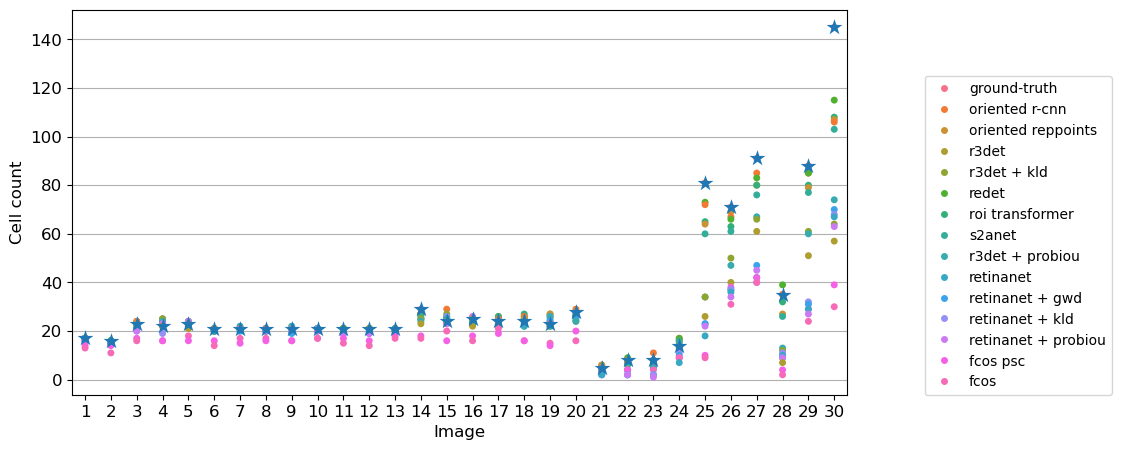

In [9]:
def plot_cell_count(df):
    plt.figure(figsize=(10, 5))
    plt.grid('on')
    fig, ax = plt.gcf(), plt.gca()
    sns.stripplot(data=df, x='img_name', y='cell_count', hue='evaluator', marker='o', size=5, jitter=False)
    sns.stripplot(data=df[df['evaluator'] == 'ground-truth'], x='img_name', y='cell_count', marker='*', size=12, jitter=False)
    plt.xlabel('Image')
    plt.ylabel('Cell count')
    plt.legend(loc=(1.1,0.0))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(12)

plot_cell_count(df_analysis)
plt.savefig(os.path.join(PATH_OUTPUT, 'plot_cell_count.png'), bbox_inches='tight')

Confluence

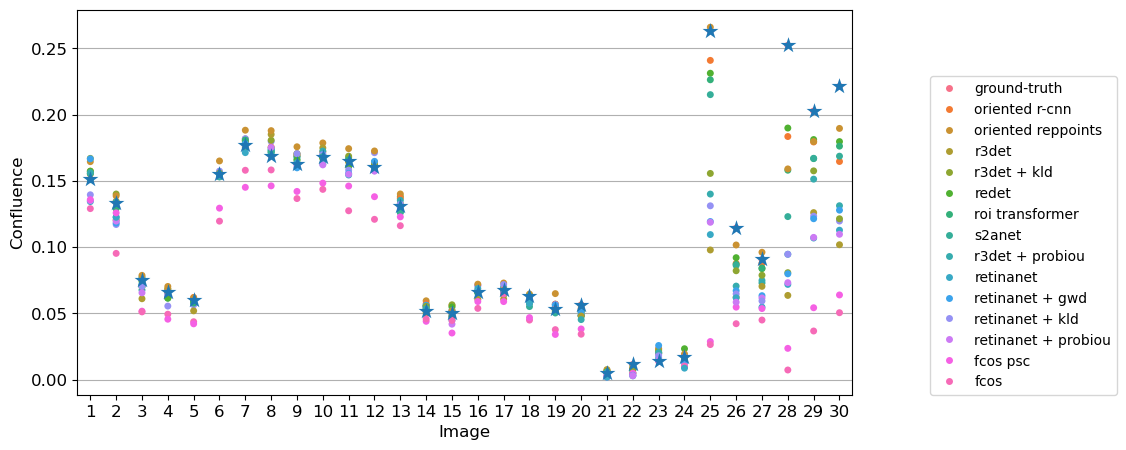

In [10]:
def plot_confluence(df):
    plt.figure(figsize=(10, 5))
    plt.grid('on')
    fig, ax = plt.gcf(), plt.gca()
    sns.stripplot(data=df, x='img_name', y='confluence', hue='evaluator', marker='o', size=5, jitter=False)
    sns.stripplot(data=df[df['evaluator'] == 'ground-truth'], x='img_name', y='confluence', marker='*', size=12, jitter=False)

    plt.xlabel('Image')
    plt.ylabel('Confluence')
    plt.legend(loc=(1.1,0.0))

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

plot_confluence(df_analysis)
plt.savefig(os.path.join(PATH_OUTPUT, 'plot_confluence.png'), bbox_inches='tight')